## Transaction Table

To make it realistic

# Income
Higher income -> Higher amount of transactions and amount in each transaction

# Age
Younger customers: smaller transactions
Middle Age Customers: moderate transactions
Older Customers: smaller transactions

# Marital Status
Married customers are more likely to transact more than single customers

# CLV
High CLV customers have larger and more frequent transaction 


In [10]:
import random
import pandas as pd
from faker import Faker
from scipy.stats import norm
from datetime import datetime

fake = Faker()

#Extract customer dataset
df_customers = pd.read_csv("../data/processed/customer.csv")
customers = df_customers.to_dict(orient="records")

NUM_TRANSACTIONS = 2500
TRANSACTION_TYPES = ["Deposit", "Withdrawal", "Transfer", "Credit"]
transactions = []

for _ in range(NUM_TRANSACTIONS):
    customer = random.choice(customers) 
    income = customer["income"]
    age = customer["age"]
    marital = customer["marital"]
    clv = customer["customer_lifetime_value"]
    
    # Adjust transaction frequency
    num_transaction = 1

    # Adjust frequency based on incomme
    if 6000 <= income <= 10000:
        num_transaction += 1
    elif income > 10000:
        num_transaction += 2

    # Adjust frequency based on marital
    if marital == 'married':
        num_transaction += 2

    # Adjust frequency based on CLV
    if 300 <= clv <= 500:
        num_transaction += 1
    elif clv > 500:
        num_transaction += 2

    TOTAL_NUM_TRANSACTION = random.randint(1, num_transaction)

    for _ in range(TOTAL_NUM_TRANSACTION):
        # Base transaction amount based on income (5% of income)
        mean_transaction = income * 0.05  
        std_transaction = mean_transaction * 0.5 

        # Adjust based on age
        if age < 30:
            mean_transaction *= 0.8
        elif 30 <= age <= 50:
            mean_transaction *= 1.0
        else:
            mean_transaction *= 0.9
        
        # Adjust based on marital status
        if marital == "married":
            mean_transaction *= 1.2
        elif marital == "single":
            mean_transaction *= 0.8

        # Adjust based on CLV
        if clv > 10:
            mean_transaction *= 1.5
        else:
            mean_transaction *= 0.8
        
        # Adding randomness
        std_transaction = mean_transaction * 0.5
        transaction_amt = max(2, round(norm.rvs(mean_transaction, std_transaction), 2))
        
        transactions.append({
            "transaction_id": fake.unique.random_int(min=100000, max=999999),
            "customer_id": customer["customer_id"],
            "transaction_type": random.choice(TRANSACTION_TYPES),
            "transaction_amt": transaction_amt,
            "transaction_date": fake.date_time_between(
                start_date=datetime(2023, 1, 1), 
                end_date=datetime(2024, 12, 31)
            ),
        })

df_transactions = pd.DataFrame(transactions)

# Save datasets (optional)
# df_customers.to_csv("customers.csv", index=False)
df_transactions.to_csv("../data/processed/transactions.csv", index=False)

# Display sample data
# print("Customer Data Sample:")
# print(df_customers.head())
print("\nTransaction Data Sample:")
print(df_transactions.head())



Transaction Data Sample:
   transaction_id  customer_id transaction_type  transaction_amt  \
0          253265         1603           Credit           764.93   
1          472773         2700          Deposit          1069.99   
2          521017         2700         Transfer          1378.95   
3          548048         2700       Withdrawal          1784.64   
4          890348         2700       Withdrawal          1061.30   

     transaction_date  
0 2024-08-04 06:48:53  
1 2023-12-03 23:26:54  
2 2024-09-12 20:27:52  
3 2024-06-05 17:42:06  
4 2023-12-19 16:24:32  


# Transaction table data analysis

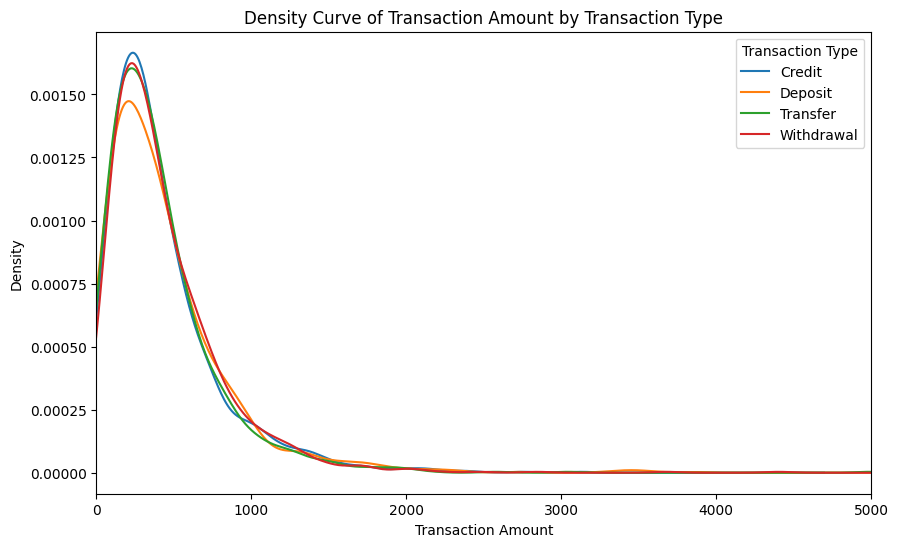

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("../data/processed/customer.csv")


# Plot density curves for transaction_amt grouped by transaction_type
plt.figure(figsize=(10, 6))  # Set figure size

# Group by transaction_type and plot KDE for each group
for ttype, group in df_transactions.groupby("transaction_type"):
    group["transaction_amt"].plot.kde(label=ttype)

# Add labels, title, and legend
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.title("Density Curve of Transaction Amount by Transaction Type")
plt.legend(title="Transaction Type")
plt.xlim(0,5000)
# Show the plot
plt.show()


# Campaign Table

In [33]:
import random
import pandas as pd

# Combine Customer and EngagementDetail data for reference
customer_df = pd.read_csv("../data/processed/customer.csv")
engagement_df = pd.read_csv("../data/processed/engagement_details.csv")
merge_df = pd.merge(customer_df, engagement_df, on="customer_id", how="inner")

# Define Languages and Duration
LANGUAGES = ["English", "Spanish", "French", "German", "Mandarin"]
DURATION = [15, 30, 45, 60, 75]

# Define campaign mappings
CHANNEL_TO_CAMPAIGN = {
    "TikTok": lambda: random.choice(["Affiliate Marketing", "Display Advertising"]),
    "Instagram": lambda: random.choice(["Affiliate Marketing", "Display Advertising"]),
    "YouTube": lambda: random.choice(["Affiliate Marketing", "Display Advertising"]),
    "Google Ads": lambda: random.choice(["Display Advertising", "Search Engine Optimization"]),
    "Email": "Email Marketing",
    "Telephone": "Telemarketing",
    "Landline": "Telemarketing",
    "Website": "Display Advertising"
}

merge_df["campaign_type"] = merge_df["channel_used"].map(CHANNEL_TO_CAMPAIGN)
merge_df["campaign_type"] = merge_df["campaign_type"].apply(lambda x: x() if callable(x) else x)

# Define target audience mappings
def map_target_audience(row):

    age = row["age"]

    # Define the age groups
    if 18 <= age <= 24:
        age_group = "18-24"
    elif 25 <= age <= 34:
        age_group = "25-34"
    elif 35 <= age <= 44:
        age_group = "35-44"
    elif 45 <= age <= 54:
        age_group = "45-54"
    else:
        age_group = "55+"

    return f"{age_group}" 

merge_df["target_audience"] = merge_df.apply(map_target_audience, axis=1)

# Extract unique campaign IDs from merge_df
unique_campaign_ids = merge_df["campaign_id"].unique()

# Generate campaign data
campaigns = []

for campaign_id in unique_campaign_ids:
    # Get all rows with this campaign_id
    campaign_rows = merge_df[merge_df["campaign_id"] == campaign_id].copy()

    campaign_rows['engagement_date'] = pd.to_datetime(
        campaign_rows['day'].astype(str) + '-' + campaign_rows['month'] + '-2025', 
        format='%d-%B-%Y', 
        errors='coerce'
    )

    # Calculate the date range (difference between max and min engagement_date)
    date_range = campaign_rows['engagement_date'].max() - campaign_rows['engagement_date'].min()

    # Calculate the actual duration in days
    actual_duration = date_range.days + 1  # Add 1 to include both start and end dates

    # Round the actual duration to the nearest value in [15, 30, 45, 60]
    campaign_duration = min([15, 30, 45, 60, 75], key=lambda x: abs(x - actual_duration))

    # Randomly pick one row (ensuring some randomness in selection)
    selected_row = campaign_rows.sample(1).iloc[0]
    
    # Extract campaign_type and target_audience
    campaign_type = selected_row["campaign_type"]
    target_audience = selected_row["target_audience"]

    # Randomly select campaign duration and language
    campaign_language = random.choice(LANGUAGES)

    # Create impressions and conversion_rate
    impressions = random.randint(1000, 50000)
    conversion_rate = round(random.uniform(0.01, 0.15), 4)  # Between 1% and 15%

    # Incorporate clicks and acquisition_cost from impressions and conversion_rate
    if campaign_type == 'Telemarketing':
        clicks = None
        base_cost_per_call = random.uniform(1,5)
        acquisition_cost = round(base_cost_per_call * impressions * conversion_rate, 2)
    
    else:
        clicks = round(impressions * conversion_rate)
        base_cost_per_click = random.uniform(1, 10)  # $1 - $10 per click
        acquisition_cost = round(base_cost_per_click * clicks, 2)

    # ROI metric
    roi = round(random.uniform(1.5, 5.0), 2)



    # Append campaign record
    campaigns.append({
        "campaign_id": campaign_id,
        "campaign_type": campaign_type,
        "target_audience": target_audience,
        "campaign_duration": campaign_duration,
        "conversion_rate": conversion_rate,
        "acquisition_cost": acquisition_cost,
        "roi": roi,
        "campaign_language": campaign_language,
        "impressions": impressions,
        "clicks": clicks
    })

# Convert to DataFrame
df_campaigns = pd.DataFrame(campaigns)
# Save to CSV (optional)
df_campaigns.to_csv("../data/processed/campaigns.csv", index=False)

